# [**Détection compressive : reconstruction tomographique avec $\ell_1$ préalable (Lasso)**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/applications/plot_tomography_l1_reconstruction.ipynb)<br/>([_Compressive sensing: tomography reconstruction with $\ell_1$ prior (Lasso_](https://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html))

Cet exemple illustre la reconstruction d'une image à partir d'un ensemble de projections parallèles acquises selon différents angles. Un tel ensemble de données est généralement obtenu en tomographie par ordinateur (CT).

En l'absence d'informations préalables sur l'échantillon, le nombre de projections nécessaires pour reconstruire l'image est de l'ordre de la taille linéaire `l` de l'image (en pixels). Pour simplifier, nous considérons ici une image parcimonieuse, où seuls les pixels situés à la frontière des objets ont une valeur non nulle. De telles données pourraient par exemple correspondre à un matériau cellulaire. Notez cependant que la plupart des images sont parcimonieuses dans une base différente, comme les ondelettes de Haar. Seulement `l/7` projections sont acquises, d'où la nécessité d'utiliser les informations préalables disponibles sur l'échantillon (sa parcimonie) : ceci est un exemple de détection compressive.

L'opération de projection tomographique est une transformation linéaire. En plus du terme de fidélité aux données correspondant à une régression linéaire, nous pénalisons la norme $\ell_1$ de l'image pour tenir compte de sa parcimonie. Le problème d'optimisation résultant est appelé Lasso. Nous utilisons la classe [**`Lasso`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), qui utilise l'algorithme de descente de coordonnées. Il est important de noter que cette implémentation est plus efficace en termes de calcul lorsqu'elle est appliquée à une matrice parcimonieuse, par rapport à l'opérateur de projection utilisé ici.

La reconstruction avec pénalisation $\ell_1$ donne un résultat sans erreur (tous les pixels sont correctement étiquetés avec 0 ou 1), même si du bruit a été ajouté aux projections. En comparaison, une pénalisation $\ell_2$ ([**`Ridge`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)) entraîne un grand nombre d'erreurs d'étiquetage pour les pixels. Des artefacts importants sont observés sur l'image reconstruite, contrairement à la pénalisation $\ell_1$. Notez en particulier l'artefact circulaire qui sépare les pixels dans les coins, lesquels ont contribué à moins de projections que le disque central.

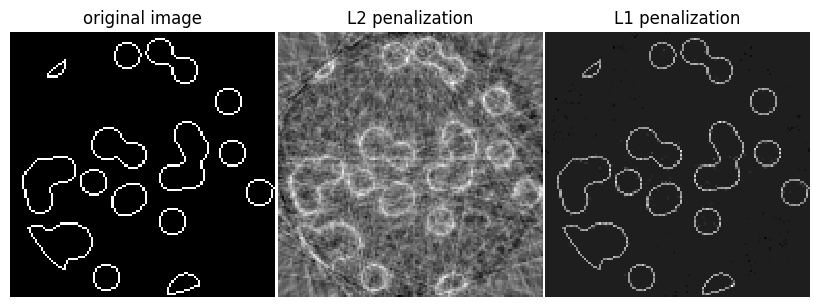

In [1]:
# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, sparse

from sklearn.linear_model import Lasso, Ridge


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    return sparse.coo_matrix((weights, (camera_inds, data_inds)))


def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 penalization")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 penalization")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()